# **PROCESSAMENTO DE IMAGEM**
## **Trabalho final da matéria**

#### **THIAGO TANURE ANDOZIA**

**FIB - Jan/2020**

**Mensagem ao professor:**

Professor, estou utilizando o Colab para o trabalho pois o python na minha máquina parou de funcionar. Por vezes tentei carregar todas as 20k imagens da base de treino para realizar o trabalho, mas o colab dava crash e eu precisava recomeçar o trabalho todo. Desta forma, fiz todo o desenvolvimento do trabalho baseado apenas nas letras A, B e C para que fosse possível, ao menos, o senhor me avaliar pelo que consegui desenvolver.

Espero que o senhor compreenda que não foi por preguiça e sim a única solução que encontrei para conseguir desenvolver o trabalho.

Por favor, qualquer dúvida, pode me contatar no whatsapp (14) 99890-8646.


Certo de sua compreensão.

In [0]:
# Para tirar o zip dos arquivos de treino
!unzip train_set

In [0]:
# Importando os pacotes
import os
import cv2
import pandas as pd
import numpy as np
import glob
from matplotlib import pyplot as plt
from google.colab import files
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from skimage.feature import hog
from skimage import data, exposure

#Metricas de avaliacao dos modelos
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix

%matplotlib inline
plt.rcParams["figure.figsize"] = [5,5]

In [0]:
# Criando as bases para o treino e o teste
x_treino = []
y_treino = []

x_teste = []
y_teste = []

# Criando as bases finais para envio
final_treino = pd.DataFrame ()
final_treino["IMAGEM"] = ()
final_treino["ANOTACAO"] = ()

final_teste = pd.DataFrame ()
final_teste["IMAGEM"] = ()
final_teste["ANOTACAO"] = ()

**BASE DE TREINO**

In [4]:
# Inserindo todas as imagens na base x e nomeando cada uma pelo nome da pasta na base y.
# Inserindo também as informações na base final para envio
fil = glob.glob ("/content/*/*.png")
for myFile in fil:
    image = cv2.imread (myFile, 0)
    x_treino.append (image) # Agregando a imagem no x
    y_treino.append (myFile[9:10]) # Agregando o label no y
    final_treino.loc[myFile, 'IMAGEM'] = myFile[11:-4] # Agregando o nome da imagem no arquivo final
    final_treino.loc[myFile, 'ANOTACAO'] = myFile[9:10] # Agregando o label da imagem no arquivo final

print('x_treino shape:', np.array(x_treino).shape) # Analisando o tamando da base de treino

x_treino shape: (2397, 128, 128)


C


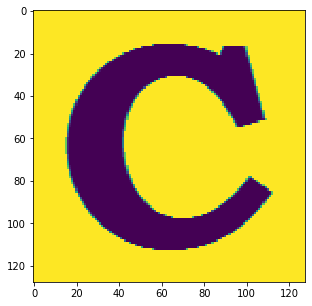

In [5]:
# Teste de verificação
plt.imshow(x_treino[1500])
print(y_treino[1500])

In [0]:
# Resetando o index da base final
final_treino = final_treino.reset_index(drop=True)

In [7]:
# Validação base treino final
final_treino.head()

,IMAGEM,ANOTACAO
0,img012-00236,B
1,img012-00584,B
2,img012-00406,B
3,img012-00472,B
4,img012-00554,B


**INICIANDO OS TRATAMENTOS NA BASE DE TREINO**

O primeiro tratamento que faremos é inverter as cores da base para que seja possível identificar as letras na cor branca e o fundo na cor preta.
Para isso, utilziaremos o método "NOT" que irá fazer o negativo das imagens.

In [0]:
# Criando uma base para alocar as imagens alteradas
x_treino_not = []

In [0]:
# Alterando as cores da imagem e do fundo
for image in x_treino:
  img = cv2.bitwise_not(image)
  x_treino_not.append(img)

C


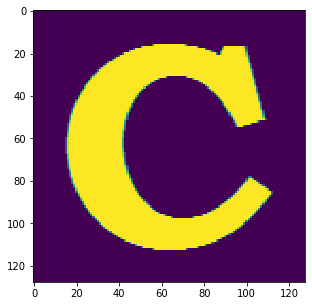

In [10]:
# Teste de verificação
plt.imshow(x_treino_not[1500])
print(y_treino[1500])

Aplicando o esqueleto

Agregaremos as definições vistas em aula para a criação do esqueleto de Zhang-Suen. Utilizei esse método por termos muitas fontes que são "desenhadas" e podem comprometer a estrutura se fizermos com o esqueleto visto anteriormente.

Escolhi atuar com esqueletos para mitigar as variações nas espessuaras das diferentes fontes

In [0]:
def neighbours(image, x, y):
    "Return 8-neighbours of image point P1(x,y), in a clockwise order"
    img = image
    x_1, y_1, x1, y1 = x-1, y-1, x+1, y+1
    
    neigh = [img[x_1][y], img[x_1][y1], img[x][y1], img[x1][y1],
             img[x1][y], img[x1][y_1], img[x][y_1], img[x_1][y_1]] 
    
    return neigh   

In [0]:
def transitions(neighbours):
    "No. of 0,1 patterns (transitions from 0 to 1) in the ordered sequence"
    n = neighbours + neighbours[0:1]
    return sum( (n1, n2) == (0, 1) for n1, n2 in zip(n, n[1:]) )

In [0]:
def zhangSuen(image):
    "the Zhang-Suen Thinning Algorithm"
    skeleton = image.copy()  # deepcopy to protect the original image
    skeleton = cv2.divide(skeleton, 255)
    changing1 = changing2 = 1        #  the points to be removed (set as 0)
    while changing1 or changing2:   #  iterates until no further changes occur in the image
        # Step 1
        changing1 = []
        rows, columns = skeleton.shape               # x for rows, y for columns
        for x in range(1, rows - 1):                     # No. of  rows
            for y in range(1, columns - 1):            # No. of columns
                P2, P3, P4, P5, P6, P7, P8, P9 = n = neighbours(skeleton, x, y)
                if (skeleton[x][y] == 1     and    # Condition 0: Point P1 in the object regions 
                    2 <= sum(n) <= 6   and    # Condition 1: 2<= N(P1) <= 6
                    transitions(n) == 1 and    # Condition 2: S(P1)=1  
                    P2 * P4 * P6 == 0  and    # Condition 3   
                    P4 * P6 * P8 == 0): # Condition 4
                    changing1.append((x,y))
        for x, y in changing1: 
            skeleton[x][y] = 0
        # Step 2
        changing2 = []
        for x in range(1, rows - 1):
            for y in range(1, columns - 1):
                P2,P3,P4,P5,P6,P7,P8,P9 = n = neighbours(skeleton, x, y)
                if (skeleton[x][y] == 1   and        # Condition 0
                    2 <= sum(n) <= 6  and       # Condition 1
                    transitions(n) == 1 and      # Condition 2
                    P2 * P4 * P8 == 0 and       # Condition 3
                    P2 * P6 * P8 == 0): # Condition 4
                    changing2.append((x,y))    
        for x, y in changing2: 
            skeleton[x][y] = 0

    skeleton = cv2.multiply(skeleton, 255)
    return skeleton

In [0]:
# Cria pasta para salvar os arquivos com esqueleto

# Fiz esse movimento por conta dos erros de crash que estavam dando. Vou deixar comentado

#root_path = '/content/ESQUELETO'
#if not os.path.isdir(root_path):
#    os.makedirs(root_path)

In [0]:
#Base com esqueleto

x_treino_esq = []
count = 0

for image in x_treino_not:
  img_skel = image
  _, img_skel = cv2.threshold(img_skel, 127, 255, cv2.THRESH_OTSU)
  skeleton_new = zhangSuen(img_skel)
  x_treino_esq.append(skeleton_new) 
  #cv2.imwrite('/content/ESQUELETO/'+str(final_treino.iloc[count][0])+'.png', skeleton_new) # Salvaria na pasta criada no bloco acima
  print(count)
  count += 1

C


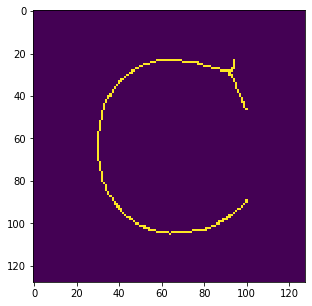

In [16]:
# Testando uma imagem com esqueleto
plt.imshow(x_treino_esq[1500])
print(y_treino[1500])

In [0]:
# Inserindo o Google Drive para fazer backup dos arquivos

# Fiz esse movimento pois como estava usando o Colab, o volume de imagens era muito grande e a sessão estava caindo constantemente e precisei reiniciar o trabalho várias vezes.

# Após montar o drive, movi a pasta de forma manual e depois baixei ela do meu google drive já com o esqueleto.

#from google.colab import drive
#drive.mount('/content/gdrive')

In [0]:
# Carregando a base de backup já com esqueleto

# Como fiz o download da base já com esqueleto, apenas carreguei a base "pronta" para extrair os descritores.

#!unzip esqueleto

#x_treino_esq = []

#fil = glob.glob ("/content/*/*.png")
#for myFile in fil:
#  image = cv2.imread (myFile, 0)
#  x_treino_esq.append (image) # Agregando a imagem no x

**INSERINDO OS DESCRITORES NA BASE DE TREINO**

Aplicando a área das imagens

In [0]:
# Criando a base para inserir as áreas
base_area = []
for img in x_treino_esq:
  _, binary_otsu = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
  cnt, hierarchy = cv2.findContours(binary_otsu, 1, 2)
  biggest = max(cnt, key = cv2.contourArea)
  area = cv2.contourArea(biggest)
  base_area.append(area)

In [0]:
# Cruzando as informações de área com as já existentes
final_treino = final_treino.join(pd.DataFrame(base_area)).rename(columns={0:'AREA_OBJ'})

In [21]:
# Validando se os dados da área foram inclusos
final_treino.head()

,IMAGEM,ANOTACAO,AREA_OBJ
0,img012-00236,B,4358.5
1,img012-00584,B,3284.0
2,img012-00406,B,3826.0
3,img012-00472,B,4358.5
4,img012-00554,B,3612.0


Aplicando Altura das imagens

In [0]:
# Criando a base para inserir as alturas
base_altura = []
for alt in x_treino_esq:
  x, y, w, h = cv2.boundingRect(alt)
  altura = h
  base_altura.append(altura)

In [0]:
# Cruzando as informações de altura com as já existentes
final_treino = final_treino.join(pd.DataFrame(base_altura)).rename(columns={0:'ALTURA'})

In [24]:
# Analisando a planilha final

final_treino.head()

,IMAGEM,ANOTACAO,AREA_OBJ,ALTURA
0,img012-00236,B,4358.5,89
1,img012-00584,B,3284.0,89
2,img012-00406,B,3826.0,81
3,img012-00472,B,4358.5,89
4,img012-00554,B,3612.0,93


Aplicando a largura das imagens

In [0]:
# Criando a base para inserir as larguras
base_largura = []
for lar in x_treino_esq:
  x, y, w, h = cv2.boundingRect(lar)
  largura = w
  base_largura.append(largura)

In [0]:
# Cruzando as informações de largura com as já existentes
final_treino = final_treino.join(pd.DataFrame(base_largura)).rename(columns={0:'LARGURA'})

In [27]:
# Analisando a planilha final

final_treino.head()

,IMAGEM,ANOTACAO,AREA_OBJ,ALTURA,LARGURA
0,img012-00236,B,4358.5,89,78
1,img012-00584,B,3284.0,89,63
2,img012-00406,B,3826.0,81,57
3,img012-00472,B,4358.5,89,78
4,img012-00554,B,3612.0,93,64


Aplicando a área do contorno

In [0]:
# Criando a base para inserir as areas
base_area2 = []
for area in x_treino_esq:
  x, y, w, h = cv2.boundingRect(area)
  objeto = w * h
  base_area2.append(objeto)

In [0]:
# Cruzando as informações de área com as já existentes
final_treino = final_treino.join(pd.DataFrame(base_area2)).rename(columns={0:'AREA_CONTORNO'})

In [30]:
final_treino.head()

,IMAGEM,ANOTACAO,AREA_OBJ,ALTURA,LARGURA,AREA_CONTORNO
0,img012-00236,B,4358.5,89,78,6942
1,img012-00584,B,3284.0,89,63,5607
2,img012-00406,B,3826.0,81,57,4617
3,img012-00472,B,4358.5,89,78,6942
4,img012-00554,B,3612.0,93,64,5952


Aplicando balanceamento horizontal

In [0]:
# Criando a base para inserir o balanceamento horizontal
balan_hor = []
for hor in x_treino_esq:
  x, y, w, h = cv2.boundingRect(hor)
  horizontal = (64-(w/2))
  balan_hor.append(horizontal)

In [0]:
# Cruzando as informações de balanceamento horizontal com as já existentes
final_treino = final_treino.join(pd.DataFrame(balan_hor)).rename(columns={0:'BALAN_HOR'})

In [33]:
# Validação

final_treino.head()

,IMAGEM,ANOTACAO,AREA_OBJ,ALTURA,LARGURA,AREA_CONTORNO,BALAN_HOR
0,img012-00236,B,4358.5,89,78,6942,25.0
1,img012-00584,B,3284.0,89,63,5607,32.5
2,img012-00406,B,3826.0,81,57,4617,35.5
3,img012-00472,B,4358.5,89,78,6942,25.0
4,img012-00554,B,3612.0,93,64,5952,32.0


Aplicando balanceamento vertical

In [0]:
# Criando a base para inserir o balanceamento vertical
balan_ver = []
for ver in x_treino_esq:
  x, y, w, h = cv2.boundingRect(ver)
  vertical = (64-(h/2))
  balan_ver.append(vertical)

In [0]:
# Cruzando as informações de balanceamento vertical com as já existentes
final_treino = final_treino.join(pd.DataFrame(balan_ver)).rename(columns={0:'BALAN_VER'})

In [36]:
# Validação

final_treino.head()

,IMAGEM,ANOTACAO,AREA_OBJ,ALTURA,LARGURA,AREA_CONTORNO,BALAN_HOR,BALAN_VER
0,img012-00236,B,4358.5,89,78,6942,25.0,19.5
1,img012-00584,B,3284.0,89,63,5607,32.5,19.5
2,img012-00406,B,3826.0,81,57,4617,35.5,23.5
3,img012-00472,B,4358.5,89,78,6942,25.0,19.5
4,img012-00554,B,3612.0,93,64,5952,32.0,17.5


Aplicando a razão das imagens

In [0]:
# Criando a base para inserir as razões
base_razao = []
for raz in x_treino_esq:
  x, y, w, h = cv2.boundingRect(raz)
  razao = h/w
  base_razao.append(razao)

In [0]:
# Cruzando as informações de razão com as já existentes
final_treino = final_treino.join(pd.DataFrame(base_razao)).rename(columns={0:'RAZAO'})

In [39]:
# Validação

final_treino.head()

,IMAGEM,ANOTACAO,AREA_OBJ,ALTURA,LARGURA,AREA_CONTORNO,BALAN_HOR,BALAN_VER,RAZAO
0,img012-00236,B,4358.5,89,78,6942,25.0,19.5,1.141026
1,img012-00584,B,3284.0,89,63,5607,32.5,19.5,1.412698
2,img012-00406,B,3826.0,81,57,4617,35.5,23.5,1.421053
3,img012-00472,B,4358.5,89,78,6942,25.0,19.5,1.141026
4,img012-00554,B,3612.0,93,64,5952,32.0,17.5,1.453125


Aplicando a compacidade

In [0]:
# Criando a base para inserir a compacidade
base_compacidade = []

for img in x_treino_esq:
  _, binary_otsu = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
  cnt, hierarchy = cv2.findContours(binary_otsu, 1, 2)
  biggest = max(cnt, key = cv2.contourArea)
  area = cv2.contourArea(biggest)
  perimetro = cv2.arcLength(biggest, True)
  compacidade = ((perimetro**2)/area) if area != 0 else 0
  base_compacidade.append(compacidade)

In [0]:
# Cruzando as informações de compacidade com as já existentes
final_treino = final_treino.join(pd.DataFrame(base_compacidade)).rename(columns={0:'COMPACIDADE'})

In [42]:
# Validação

final_treino.head()

,IMAGEM,ANOTACAO,AREA_OBJ,ALTURA,LARGURA,AREA_CONTORNO,BALAN_HOR,BALAN_VER,RAZAO,COMPACIDADE
0,img012-00236,B,4358.5,89,78,6942,25.0,19.5,1.141026,22.225269
1,img012-00584,B,3284.0,89,63,5607,32.5,19.5,1.412698,25.311170
2,img012-00406,B,3826.0,81,57,4617,35.5,23.5,1.421053,17.699231
3,img012-00472,B,4358.5,89,78,6942,25.0,19.5,1.141026,22.225269
4,img012-00554,B,3612.0,93,64,5952,32.0,17.5,1.453125,32.847826


Aplicando o perímetro do contorno

In [0]:
# Criando a base para inserir o perímetro do contorno
base_perimetro = []

for img in x_treino_esq:
  _, binary_otsu = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
  cnt, hierarchy = cv2.findContours(binary_otsu, 1, 2)
  biggest = max(cnt, key = cv2.contourArea)
  perimetro = cv2.arcLength(biggest, True)
  base_perimetro.append(perimetro)

In [0]:
# Cruzando as informações de perímetro com as já existentes
final_treino = final_treino.join(pd.DataFrame(base_perimetro)).rename(columns={0:'PERIM_CONTORNO'})

In [45]:
# Validação

final_treino.head()

,IMAGEM,ANOTACAO,AREA_OBJ,ALTURA,LARGURA,AREA_CONTORNO,BALAN_HOR,BALAN_VER,RAZAO,COMPACIDADE,PERIM_CONTORNO
0,img012-00236,B,4358.5,89,78,6942,25.0,19.5,1.141026,22.225269,311.237588
1,img012-00584,B,3284.0,89,63,5607,32.5,19.5,1.412698,25.311170,288.308656
2,img012-00406,B,3826.0,81,57,4617,35.5,23.5,1.421053,17.699231,260.225396
3,img012-00472,B,4358.5,89,78,6942,25.0,19.5,1.141026,22.225269,311.237588
4,img012-00554,B,3612.0,93,64,5952,32.0,17.5,1.453125,32.847826,344.450791


Aplicando a retangularidade

In [0]:
# Como já temos os valores de área, largura e altura calculados na tabela, vamos fazer o cálculo diretamente

final_treino['RETANG.'] = final_treino['AREA_OBJ'] / (final_treino['ALTURA'] * final_treino['LARGURA'])

In [47]:
# Validação

final_treino.head()

,IMAGEM,ANOTACAO,AREA_OBJ,ALTURA,LARGURA,AREA_CONTORNO,BALAN_HOR,BALAN_VER,RAZAO,COMPACIDADE,PERIM_CONTORNO,RETANG.
0,img012-00236,B,4358.5,89,78,6942,25.0,19.5,1.141026,22.225269,311.237588,0.627845
1,img012-00584,B,3284.0,89,63,5607,32.5,19.5,1.412698,25.311170,288.308656,0.585696
2,img012-00406,B,3826.0,81,57,4617,35.5,23.5,1.421053,17.699231,260.225396,0.828677
3,img012-00472,B,4358.5,89,78,6942,25.0,19.5,1.141026,22.225269,311.237588,0.627845
4,img012-00554,B,3612.0,93,64,5952,32.0,17.5,1.453125,32.847826,344.450791,0.606855


Aplicando o número de Euler

In [0]:
# Criando a base para inserir o número de Euler
base_euler = []

for img in x_treino_esq:
  contornos,_ = cv2.findContours(img,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)
  euler = 2 - len(contornos) # Tiramos 2 do contorno pois 1 representa a letra em si e o outro 1 é da fórmula.
  base_euler.append(euler)

In [0]:
# Cruzando as informações de Euler com as já existentes
final_treino = final_treino.join(pd.DataFrame(base_euler)).rename(columns={0:'EULER'})

In [50]:
# Validação

final_treino.head()

,IMAGEM,ANOTACAO,AREA_OBJ,ALTURA,LARGURA,AREA_CONTORNO,BALAN_HOR,BALAN_VER,RAZAO,COMPACIDADE,PERIM_CONTORNO,RETANG.,EULER
0,img012-00236,B,4358.5,89,78,6942,25.0,19.5,1.141026,22.225269,311.237588,0.627845,-1
1,img012-00584,B,3284.0,89,63,5607,32.5,19.5,1.412698,25.311170,288.308656,0.585696,-1
2,img012-00406,B,3826.0,81,57,4617,35.5,23.5,1.421053,17.699231,260.225396,0.828677,-1
3,img012-00472,B,4358.5,89,78,6942,25.0,19.5,1.141026,22.225269,311.237588,0.627845,-1
4,img012-00554,B,3612.0,93,64,5952,32.0,17.5,1.453125,32.847826,344.450791,0.606855,-1


Aplicando a área e perimetro do fecho convexo

In [0]:
# Criando a base para inserir as áreas
base_area3 = []
base_perimetro2 = []

for img in x_treino_esq:
  _, binary_otsu = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
  cnt, hierarchy = cv2.findContours(binary_otsu, 1, 2)
  biggest = max(cnt, key = cv2.contourArea)
  hull = cv2.convexHull(biggest)
  area = cv2.contourArea(hull)
  base_area3.append(area)
  perimetro = cv2.arcLength(hull, True)
  base_perimetro2.append(perimetro)

In [0]:
# Cruzando as informações de área e perímetro do fecho com as já existentes
final_treino = final_treino.join(pd.DataFrame(base_area3)).rename(columns={0:'AREA_FECHO'})
final_treino = final_treino.join(pd.DataFrame(base_perimetro2)).rename(columns={0:'PERIM_FECHO'})

In [53]:
# Validação

final_treino.head()

,IMAGEM,ANOTACAO,AREA_OBJ,ALTURA,LARGURA,AREA_CONTORNO,BALAN_HOR,BALAN_VER,RAZAO,COMPACIDADE,PERIM_CONTORNO,RETANG.,EULER,AREA_FECHO,PERIM_FECHO
0,img012-00236,B,4358.5,89,78,6942,25.0,19.5,1.141026,22.225269,311.237588,0.627845,-1,5053.5,282.962375
1,img012-00584,B,3284.0,89,63,5607,32.5,19.5,1.412698,25.311170,288.308656,0.585696,-1,3929.5,256.980317
2,img012-00406,B,3826.0,81,57,4617,35.5,23.5,1.421053,17.699231,260.225396,0.828677,-1,4054.0,246.749827
3,img012-00472,B,4358.5,89,78,6942,25.0,19.5,1.141026,22.225269,311.237588,0.627845,-1,5053.5,282.962375
4,img012-00554,B,3612.0,93,64,5952,32.0,17.5,1.453125,32.847826,344.450791,0.606855,-1,5469.0,289.761270


Aplicando a convexidade

In [0]:
# Como já temos os valores de perímetro do fecho e do contorno na tabela, vamos fazer o cálculo diretamente

final_treino['CONVEXIDADE'] = final_treino['PERIM_FECHO'] / final_treino['PERIM_CONTORNO']

In [55]:
# Validação

final_treino.head()

,IMAGEM,ANOTACAO,AREA_OBJ,ALTURA,LARGURA,AREA_CONTORNO,BALAN_HOR,BALAN_VER,RAZAO,COMPACIDADE,PERIM_CONTORNO,RETANG.,EULER,AREA_FECHO,PERIM_FECHO,CONVEXIDADE
0,img012-00236,B,4358.5,89,78,6942,25.0,19.5,1.141026,22.225269,311.237588,0.627845,-1,5053.5,282.962375,0.909152
1,img012-00584,B,3284.0,89,63,5607,32.5,19.5,1.412698,25.311170,288.308656,0.585696,-1,3929.5,256.980317,0.891338
2,img012-00406,B,3826.0,81,57,4617,35.5,23.5,1.421053,17.699231,260.225396,0.828677,-1,4054.0,246.749827,0.948216
3,img012-00472,B,4358.5,89,78,6942,25.0,19.5,1.141026,22.225269,311.237588,0.627845,-1,5053.5,282.962375,0.909152
4,img012-00554,B,3612.0,93,64,5952,32.0,17.5,1.453125,32.847826,344.450791,0.606855,-1,5469.0,289.761270,0.841227


Aplicando a solidez

In [0]:
# Como já temos os valores de área do fecho e do contorno na tabela, vamos fazer o cálculo diretamente

final_treino['SOLIDEZ'] = final_treino['AREA_CONTORNO'] / final_treino['AREA_FECHO']

In [57]:
# Validação

final_treino.head()

,IMAGEM,ANOTACAO,AREA_OBJ,ALTURA,LARGURA,AREA_CONTORNO,BALAN_HOR,BALAN_VER,RAZAO,COMPACIDADE,PERIM_CONTORNO,RETANG.,EULER,AREA_FECHO,PERIM_FECHO,CONVEXIDADE,SOLIDEZ
0,img012-00236,B,4358.5,89,78,6942,25.0,19.5,1.141026,22.225269,311.237588,0.627845,-1,5053.5,282.962375,0.909152,1.373701
1,img012-00584,B,3284.0,89,63,5607,32.5,19.5,1.412698,25.311170,288.308656,0.585696,-1,3929.5,256.980317,0.891338,1.426899
2,img012-00406,B,3826.0,81,57,4617,35.5,23.5,1.421053,17.699231,260.225396,0.828677,-1,4054.0,246.749827,0.948216,1.138875
3,img012-00472,B,4358.5,89,78,6942,25.0,19.5,1.141026,22.225269,311.237588,0.627845,-1,5053.5,282.962375,0.909152,1.373701
4,img012-00554,B,3612.0,93,64,5952,32.0,17.5,1.453125,32.847826,344.450791,0.606855,-1,5469.0,289.761270,0.841227,1.088316


Nrmalizando a base

In [58]:
# Criando a escala

scaler = StandardScaler()
scaler.fit(final_treino.iloc[:,3:17])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [59]:
# Escalando a base de treino

final_treino_scaled = pd.DataFrame(scaler.transform(final_treino.iloc[:,3:17]))
final_treino_scaled.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.303837,0.439304,0.576152,-0.439304,-0.303837,-0.339693,-0.341409,-0.740824,1.292940,-0.585307,0.820618,0.849431,1.255755,-0.032766
1,0.303837,-0.649192,-0.490560,0.649192,-0.303837,0.377600,-0.341098,-1.012867,1.141268,-0.585307,-0.262385,-0.247545,1.129855,-0.028727
2,-0.755505,-1.084591,-1.281604,1.084591,0.755505,0.399657,-0.341866,-1.346063,2.015631,-0.585307,-0.142426,-0.679482,1.531824,-0.050592
3,0.303837,0.439304,0.576152,-0.439304,-0.303837,-0.339693,-0.341409,-0.740824,1.292940,-0.585307,0.820618,0.849431,1.255755,-0.032766
4,0.833509,-0.576626,-0.214893,0.576626,-0.833509,0.484337,-0.340337,-0.346762,1.217407,-0.585307,1.220963,1.136484,0.775714,-0.054430


Aplicando o K-means no treino

In [60]:
# Criando o modelo e dando fit na base escalada

kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans.fit(final_treino_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

In [0]:
# Rodando o predict e já agregando na base final

final_treino['pred_y_kmeans'] = kmeans.predict(final_treino_scaled)

In [62]:
# Validação

final_treino.head()

,IMAGEM,ANOTACAO,AREA_OBJ,ALTURA,LARGURA,AREA_CONTORNO,BALAN_HOR,BALAN_VER,RAZAO,COMPACIDADE,PERIM_CONTORNO,RETANG.,EULER,AREA_FECHO,PERIM_FECHO,CONVEXIDADE,SOLIDEZ,pred_y_kmeans
0,img012-00236,B,4358.5,89,78,6942,25.0,19.5,1.141026,22.225269,311.237588,0.627845,-1,5053.5,282.962375,0.909152,1.373701,0
1,img012-00584,B,3284.0,89,63,5607,32.5,19.5,1.412698,25.311170,288.308656,0.585696,-1,3929.5,256.980317,0.891338,1.426899,2
2,img012-00406,B,3826.0,81,57,4617,35.5,23.5,1.421053,17.699231,260.225396,0.828677,-1,4054.0,246.749827,0.948216,1.138875,2
3,img012-00472,B,4358.5,89,78,6942,25.0,19.5,1.141026,22.225269,311.237588,0.627845,-1,5053.5,282.962375,0.909152,1.373701,0
4,img012-00554,B,3612.0,93,64,5952,32.0,17.5,1.453125,32.847826,344.450791,0.606855,-1,5469.0,289.761270,0.841227,1.088316,0


Aplicando Random Forest no treino

In [63]:
# Criando o modelo de RF e dando fit na base escalada com o rótulo sendo a coluna "Anotação" da base final

model_rf = RandomForestClassifier()
model_rf.fit(final_treino_scaled, final_treino['ANOTACAO'])

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
# Predict na base e já agregando a coluna ao final

final_treino['pred_y_rf'] = model_rf.predict(final_treino_scaled)

In [65]:
# Validação

final_treino.head()

,IMAGEM,ANOTACAO,AREA_OBJ,ALTURA,LARGURA,AREA_CONTORNO,BALAN_HOR,BALAN_VER,RAZAO,COMPACIDADE,PERIM_CONTORNO,RETANG.,EULER,AREA_FECHO,PERIM_FECHO,CONVEXIDADE,SOLIDEZ,pred_y_kmeans,pred_y_rf
0,img012-00236,B,4358.5,89,78,6942,25.0,19.5,1.141026,22.225269,311.237588,0.627845,-1,5053.5,282.962375,0.909152,1.373701,0,B
1,img012-00584,B,3284.0,89,63,5607,32.5,19.5,1.412698,25.311170,288.308656,0.585696,-1,3929.5,256.980317,0.891338,1.426899,2,B
2,img012-00406,B,3826.0,81,57,4617,35.5,23.5,1.421053,17.699231,260.225396,0.828677,-1,4054.0,246.749827,0.948216,1.138875,2,B
3,img012-00472,B,4358.5,89,78,6942,25.0,19.5,1.141026,22.225269,311.237588,0.627845,-1,5053.5,282.962375,0.909152,1.373701,0,B
4,img012-00554,B,3612.0,93,64,5952,32.0,17.5,1.453125,32.847826,344.450791,0.606855,-1,5469.0,289.761270,0.841227,1.088316,0,B


In [66]:
# Validação cruzada entre o rótulo e os grupos descobertos pelo Kmeans

pd.crosstab(final_treino["ANOTACAO"],final_treino["pred_y_kmeans"]).apply(lambda r: r/r.sum()*100, axis=1)

pred_y_kmeans,0,1,2
ANOTACAO,,,
A,62.327910,13.016270,24.655820
B,45.556946,6.257822,48.185232
C,63.829787,4.881101,31.289111


In [67]:
# Validação cruzada entre o rótulo e a Random Forest
pd.crosstab(final_treino["ANOTACAO"],final_treino["pred_y_rf"]).apply(lambda r: r/r.sum()*100, axis=1)

pred_y_rf,A,B,C
ANOTACAO,,,
A,99.874844,0.000000,0.125156
B,0.125156,99.874844,0.000000
C,0.000000,0.000000,100.000000


Aqui já podemos analisar que o modelo de árvores performou muito superior ao K-means com os parâmetros default. Vamos aplicar na base de testes e também comparar com o HOG para analisar e comparar as performances.

Criando a base HOG (treino) e aplicando o K-means e random forest na mesma

In [0]:
# HOG
base_hog = []

for img in x_treino_esq:
  fd, hog_image = hog(img, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True, multichannel=False)
  base_hog.append(hog_image)

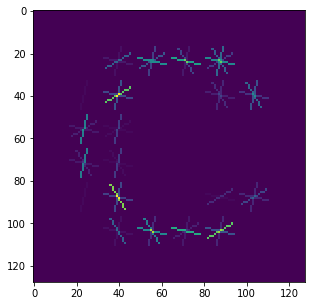

In [70]:
# Visualizando uma imagem com HOG

plt.imshow(base_hog[1500])

In [0]:
# Ajustando as dimensões da base para aplicação do k-means

base_hog_ok = np.array(base_hog)
nsamples, nx, ny = base_hog_ok.shape
base_hog_final = base_hog_ok.reshape((nsamples,nx*ny))

In [0]:
# Construindo os modelos na base HOG

# K-means

kmeans_hog = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans_hog.fit(base_hog_final)

final_treino['pred_y_kmeans_hog'] = kmeans_hog.predict(base_hog_final)

In [73]:
# Validação

final_treino.head()

,IMAGEM,ANOTACAO,AREA_OBJ,ALTURA,LARGURA,AREA_CONTORNO,BALAN_HOR,BALAN_VER,RAZAO,COMPACIDADE,PERIM_CONTORNO,RETANG.,EULER,AREA_FECHO,PERIM_FECHO,CONVEXIDADE,SOLIDEZ,pred_y_kmeans,pred_y_rf,pred_y_kmeans_hog
0,img012-00236,B,4358.5,89,78,6942,25.0,19.5,1.141026,22.225269,311.237588,0.627845,-1,5053.5,282.962375,0.909152,1.373701,0,B,2
1,img012-00584,B,3284.0,89,63,5607,32.5,19.5,1.412698,25.311170,288.308656,0.585696,-1,3929.5,256.980317,0.891338,1.426899,2,B,2
2,img012-00406,B,3826.0,81,57,4617,35.5,23.5,1.421053,17.699231,260.225396,0.828677,-1,4054.0,246.749827,0.948216,1.138875,2,B,2
3,img012-00472,B,4358.5,89,78,6942,25.0,19.5,1.141026,22.225269,311.237588,0.627845,-1,5053.5,282.962375,0.909152,1.373701,0,B,2
4,img012-00554,B,3612.0,93,64,5952,32.0,17.5,1.453125,32.847826,344.450791,0.606855,-1,5469.0,289.761270,0.841227,1.088316,0,B,2


In [74]:
# Validação cruzada entre o rótulo e os grupos descobertos pelo Kmeans_hog

pd.crosstab(final_treino["ANOTACAO"],final_treino["pred_y_kmeans_hog"]).apply(lambda r: r/r.sum()*100, axis=1)

pred_y_kmeans_hog,0,1,2
ANOTACAO,,,
A,98.748436,1.251564,0.000000
B,13.391740,1.627034,84.981227
C,6.758448,92.740926,0.500626


Como podemos notar, quando aplicamos o HOG o k-means melhora consideravelmente sua assertividade, quando comparado com a aplicação feita nos descritores anteriores.

In [75]:
# Criando o modelo de RF e dando fit na base HOG com o rótulo sendo a coluna "Anotação" da base final

model_rf_hog = RandomForestClassifier()
model_rf_hog.fit(base_hog_final, final_treino['ANOTACAO'])

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
# Predict na base HOG e já agregando a coluna ao final

final_treino['pred_y_rf_hog'] = model_rf_hog.predict(base_hog_final)

In [77]:
# Validação

final_treino.head()

,IMAGEM,ANOTACAO,AREA_OBJ,ALTURA,LARGURA,AREA_CONTORNO,BALAN_HOR,BALAN_VER,RAZAO,COMPACIDADE,PERIM_CONTORNO,RETANG.,EULER,AREA_FECHO,PERIM_FECHO,CONVEXIDADE,SOLIDEZ,pred_y_kmeans,pred_y_rf,pred_y_kmeans_hog,pred_y_rf_hog
0,img012-00236,B,4358.5,89,78,6942,25.0,19.5,1.141026,22.225269,311.237588,0.627845,-1,5053.5,282.962375,0.909152,1.373701,0,B,2,B
1,img012-00584,B,3284.0,89,63,5607,32.5,19.5,1.412698,25.311170,288.308656,0.585696,-1,3929.5,256.980317,0.891338,1.426899,2,B,2,B
2,img012-00406,B,3826.0,81,57,4617,35.5,23.5,1.421053,17.699231,260.225396,0.828677,-1,4054.0,246.749827,0.948216,1.138875,2,B,2,B
3,img012-00472,B,4358.5,89,78,6942,25.0,19.5,1.141026,22.225269,311.237588,0.627845,-1,5053.5,282.962375,0.909152,1.373701,0,B,2,B
4,img012-00554,B,3612.0,93,64,5952,32.0,17.5,1.453125,32.847826,344.450791,0.606855,-1,5469.0,289.761270,0.841227,1.088316,0,B,2,B


In [78]:
# Validação cruzada entre o rótulo e os grupos descobertos pelo RF_hog

pd.crosstab(final_treino["ANOTACAO"],final_treino["pred_y_rf_hog"]).apply(lambda r: r/r.sum()*100, axis=1)

pred_y_rf_hog,A,B,C
ANOTACAO,,,
A,100.0,0.000000,0.000000
B,0.0,100.000000,0.000000
C,0.0,0.125156,99.874844


Como podemos notar, o modelo de HOG + Random Forest consegue 100% de assertividade no treino. Vamos fazer agora todas as aplicações na base de teste.

**BASE DE TESTE**

In [0]:
# Para tirar o zip dos arquivos de teste
!unzip teste_set

In [80]:
# Inserindo todas as imagens na base x
# Inserindo também as informações na base final para envio
fil = glob.glob ("/content/*.png")
for myFile in fil:
    image = cv2.imread (myFile, 0)
    x_teste.append (image) # Agregando a imagem no x
    final_teste.loc[myFile, 'IMAGEM'] = myFile[9:-4] # Agregando o nome da imagem no arquivo final
    final_teste.loc[myFile, 'ANOTACAO'] = myFile[9:15] # Agregando o nome da imagem (6 primeiro digitos)

print('x_teste shape:', np.array(x_teste).shape) # Analisando o tamando da base

x_teste shape: (615, 128, 128)


In [0]:
# Resetando o index da base final
final_teste = final_teste.reset_index(drop=True)

**INICIANDO OS TRATAMENTOS NA BASE DE TESTE**

In [0]:
# Criando uma base para alocar as imagens alteradas
x_teste_not = []

In [0]:
# Alterando as cores da imagem e do fundo
for image in x_teste:
  img = cv2.bitwise_not(image)
  x_teste_not.append(img)

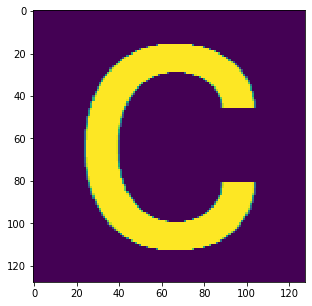

In [84]:
# Teste de verificação
plt.imshow(x_teste_not[150])

Aplicando o esqueleto

In [0]:
#Base com esqueleto

x_teste_esq = []
count = 0

for image in x_teste_not:
  img_skel = image
  _, img_skel = cv2.threshold(img_skel, 127, 255, cv2.THRESH_OTSU)
  skeleton_new = zhangSuen(img_skel)
  x_teste_esq.append(skeleton_new) 
  print(count)
  count += 1

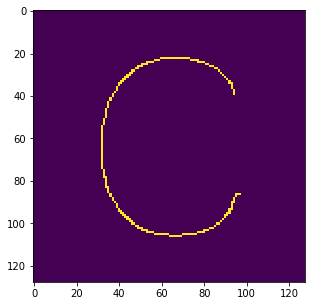

In [86]:
# Testando uma imagem com esqueleto
plt.imshow(x_teste_esq[150])

**INSERINDO OS DESCRITORES NA BASE DE TESTE**

Aplicando a área das imagens

In [0]:
# Criando a base para inserir as áreas
base_area = []
for img in x_teste_esq:
  _, binary_otsu = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
  cnt, hierarchy = cv2.findContours(binary_otsu, 1, 2)
  biggest = max(cnt, key = cv2.contourArea)
  area = cv2.contourArea(biggest)
  base_area.append(area)

In [0]:
# Cruzando as informações de área com as já existentes
final_teste = final_teste.join(pd.DataFrame(base_area)).rename(columns={0:'AREA_OBJ'})

In [89]:
# Validando se os dados da área foram inclusos
final_teste.head()

,IMAGEM,ANOTACAO,AREA_OBJ
0,img013-00999,img013,262.5
1,img013-00985,img013,19.5
2,img013-00983,img013,25.5
3,img011-00856,img011,978.0
4,img012-00847,img012,4432.5


Aplicando Altura das imagens

In [0]:
# Criando a base para inserir as alturas
base_altura = []
for alt in x_teste_esq:
  x, y, w, h = cv2.boundingRect(alt)
  altura = h
  base_altura.append(altura)

In [0]:
# Cruzando as informações de altura com as já existentes
final_teste = final_teste.join(pd.DataFrame(base_altura)).rename(columns={0:'ALTURA'})

In [92]:
# Analisando a planilha final

final_teste.head()

,IMAGEM,ANOTACAO,AREA_OBJ,ALTURA
0,img013-00999,img013,262.5,68
1,img013-00985,img013,19.5,88
2,img013-00983,img013,25.5,88
3,img011-00856,img011,978.0,64
4,img012-00847,img012,4432.5,89


Aplicando a largura das imagens

In [0]:
# Criando a base para inserir as larguras
base_largura = []
for lar in x_teste_esq:
  x, y, w, h = cv2.boundingRect(lar)
  largura = w
  base_largura.append(largura)

In [0]:
# Cruzando as informações de largura com as já existentes
final_teste = final_teste.join(pd.DataFrame(base_largura)).rename(columns={0:'LARGURA'})

In [95]:
# Analisando a planilha final

final_teste.head()

,IMAGEM,ANOTACAO,AREA_OBJ,ALTURA,LARGURA
0,img013-00999,img013,262.5,68,95
1,img013-00985,img013,19.5,88,71
2,img013-00983,img013,25.5,88,71
3,img011-00856,img011,978.0,64,86
4,img012-00847,img012,4432.5,89,82


Aplicando a área do contorno

In [0]:
# Criando a base para inserir as areas
base_area2 = []
for area in x_teste_esq:
  x, y, w, h = cv2.boundingRect(area)
  objeto = w * h
  base_area2.append(objeto)

In [0]:
# Cruzando as informações de área com as já existentes
final_teste = final_teste.join(pd.DataFrame(base_area2)).rename(columns={0:'AREA_CONTORNO'})

In [98]:
final_teste.head()

,IMAGEM,ANOTACAO,AREA_OBJ,ALTURA,LARGURA,AREA_CONTORNO
0,img013-00999,img013,262.5,68,95,6460
1,img013-00985,img013,19.5,88,71,6248
2,img013-00983,img013,25.5,88,71,6248
3,img011-00856,img011,978.0,64,86,5504
4,img012-00847,img012,4432.5,89,82,7298


Aplicando balanceamento horizontal

In [0]:
# Criando a base para inserir o balanceamento horizontal
balan_hor = []
for hor in x_teste_esq:
  x, y, w, h = cv2.boundingRect(hor)
  horizontal = (64-(w/2))
  balan_hor.append(horizontal)

In [0]:
# Cruzando as informações de balanceamento horizontal com as já existentes
final_teste = final_teste.join(pd.DataFrame(balan_hor)).rename(columns={0:'BALAN_HOR'})

In [101]:
# Validação

final_teste.head()

,IMAGEM,ANOTACAO,AREA_OBJ,ALTURA,LARGURA,AREA_CONTORNO,BALAN_HOR
0,img013-00999,img013,262.5,68,95,6460,16.5
1,img013-00985,img013,19.5,88,71,6248,28.5
2,img013-00983,img013,25.5,88,71,6248,28.5
3,img011-00856,img011,978.0,64,86,5504,21.0
4,img012-00847,img012,4432.5,89,82,7298,23.0


Aplicando balanceamento vertical

In [0]:
# Criando a base para inserir o balanceamento vertical
balan_ver = []
for ver in x_teste_esq:
  x, y, w, h = cv2.boundingRect(ver)
  vertical = (64-(h/2))
  balan_ver.append(vertical)

In [0]:
# Cruzando as informações de balanceamento vertical com as já existentes
final_teste = final_teste.join(pd.DataFrame(balan_ver)).rename(columns={0:'BALAN_VER'})

In [104]:
# Validação

final_teste.head()

,IMAGEM,ANOTACAO,AREA_OBJ,ALTURA,LARGURA,AREA_CONTORNO,BALAN_HOR,BALAN_VER
0,img013-00999,img013,262.5,68,95,6460,16.5,30.0
1,img013-00985,img013,19.5,88,71,6248,28.5,20.0
2,img013-00983,img013,25.5,88,71,6248,28.5,20.0
3,img011-00856,img011,978.0,64,86,5504,21.0,32.0
4,img012-00847,img012,4432.5,89,82,7298,23.0,19.5


Aplicando a razão das imagens

In [0]:
# Criando a base para inserir as razões
base_razao = []
for raz in x_teste_esq:
  x, y, w, h = cv2.boundingRect(raz)
  razao = h/w
  base_razao.append(razao)

In [0]:
# Cruzando as informações de razão com as já existentes
final_teste = final_teste.join(pd.DataFrame(base_razao)).rename(columns={0:'RAZAO'})

In [107]:
# Validação

final_teste.head()

,IMAGEM,ANOTACAO,AREA_OBJ,ALTURA,LARGURA,AREA_CONTORNO,BALAN_HOR,BALAN_VER,RAZAO
0,img013-00999,img013,262.5,68,95,6460,16.5,30.0,0.715789
1,img013-00985,img013,19.5,88,71,6248,28.5,20.0,1.239437
2,img013-00983,img013,25.5,88,71,6248,28.5,20.0,1.239437
3,img011-00856,img011,978.0,64,86,5504,21.0,32.0,0.744186
4,img012-00847,img012,4432.5,89,82,7298,23.0,19.5,1.085366


Aplicando a compacidade

In [0]:
# Criando a base para inserir a compacidade
base_compacidade = []

for img in x_teste_esq:
  _, binary_otsu = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
  cnt, hierarchy = cv2.findContours(binary_otsu, 1, 2)
  biggest = max(cnt, key = cv2.contourArea)
  area = cv2.contourArea(biggest)
  perimetro = cv2.arcLength(biggest, True)
  compacidade = ((perimetro**2)/area) if area != 0 else 0
  base_compacidade.append(compacidade)

In [0]:
# Cruzando as informações de compacidade com as já existentes
final_teste = final_teste.join(pd.DataFrame(base_compacidade)).rename(columns={0:'COMPACIDADE'})

In [110]:
# Validação

final_teste.head()

,IMAGEM,ANOTACAO,AREA_OBJ,ALTURA,LARGURA,AREA_CONTORNO,BALAN_HOR,BALAN_VER,RAZAO,COMPACIDADE
0,img013-00999,img013,262.5,68,95,6460,16.5,30.0,0.715789,792.535990
1,img013-00985,img013,19.5,88,71,6248,28.5,20.0,1.239437,9626.458311
2,img013-00983,img013,25.5,88,71,6248,28.5,20.0,1.239437,8000.878151
3,img011-00856,img011,978.0,64,86,5504,21.0,32.0,0.744186,144.967169
4,img012-00847,img012,4432.5,89,82,7298,23.0,19.5,1.085366,21.757949


Aplicando o perímetro do contorno

In [0]:
# Criando a base para inserir o perímetro do contorno
base_perimetro = []

for img in x_teste_esq:
  _, binary_otsu = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
  cnt, hierarchy = cv2.findContours(binary_otsu, 1, 2)
  biggest = max(cnt, key = cv2.contourArea)
  perimetro = cv2.arcLength(biggest, True)
  base_perimetro.append(perimetro)

In [0]:
# Cruzando as informações de perímetro com as já existentes
final_teste = final_teste.join(pd.DataFrame(base_perimetro)).rename(columns={0:'PERIM_CONTORNO'})

In [113]:
# Validação

final_teste.head()

,IMAGEM,ANOTACAO,AREA_OBJ,ALTURA,LARGURA,AREA_CONTORNO,BALAN_HOR,BALAN_VER,RAZAO,COMPACIDADE,PERIM_CONTORNO
0,img013-00999,img013,262.5,68,95,6460,16.5,30.0,0.715789,792.535990,456.114785
1,img013-00985,img013,19.5,88,71,6248,28.5,20.0,1.239437,9626.458311,433.261973
2,img013-00983,img013,25.5,88,71,6248,28.5,20.0,1.239437,8000.878151,451.688380
3,img011-00856,img011,978.0,64,86,5504,21.0,32.0,0.744186,144.967169,376.534051
4,img012-00847,img012,4432.5,89,82,7298,23.0,19.5,1.085366,21.757949,310.551297


Aplicando a retangularidade

In [0]:
# Como já temos os valores de área, largura e altura calculados na tabela, vamos fazer o cálculo diretamente

final_teste['RETANG.'] = final_teste['AREA_OBJ'] / (final_teste['ALTURA'] * final_teste['LARGURA'])

In [115]:
# Validação

final_teste.head()

,IMAGEM,ANOTACAO,AREA_OBJ,ALTURA,LARGURA,AREA_CONTORNO,BALAN_HOR,BALAN_VER,RAZAO,COMPACIDADE,PERIM_CONTORNO,RETANG.
0,img013-00999,img013,262.5,68,95,6460,16.5,30.0,0.715789,792.535990,456.114785,0.040635
1,img013-00985,img013,19.5,88,71,6248,28.5,20.0,1.239437,9626.458311,433.261973,0.003121
2,img013-00983,img013,25.5,88,71,6248,28.5,20.0,1.239437,8000.878151,451.688380,0.004081
3,img011-00856,img011,978.0,64,86,5504,21.0,32.0,0.744186,144.967169,376.534051,0.177689
4,img012-00847,img012,4432.5,89,82,7298,23.0,19.5,1.085366,21.757949,310.551297,0.607358


Aplicando o número de Euler

In [0]:
# Criando a base para inserir o número de Euler
base_euler = []

for img in x_teste_esq:
  contornos,_ = cv2.findContours(img,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)
  euler = 2 - len(contornos) # Tiramos 2 do contorno pois 1 representa a letra em si e o outro 1 é da fórmula.
  base_euler.append(euler)

In [0]:
# Cruzando as informações de Euler com as já existentes
final_teste = final_teste.join(pd.DataFrame(base_euler)).rename(columns={0:'EULER'})

In [118]:
# Validação

final_teste.head()

,IMAGEM,ANOTACAO,AREA_OBJ,ALTURA,LARGURA,AREA_CONTORNO,BALAN_HOR,BALAN_VER,RAZAO,COMPACIDADE,PERIM_CONTORNO,RETANG.,EULER
0,img013-00999,img013,262.5,68,95,6460,16.5,30.0,0.715789,792.535990,456.114785,0.040635,-1
1,img013-00985,img013,19.5,88,71,6248,28.5,20.0,1.239437,9626.458311,433.261973,0.003121,1
2,img013-00983,img013,25.5,88,71,6248,28.5,20.0,1.239437,8000.878151,451.688380,0.004081,1
3,img011-00856,img011,978.0,64,86,5504,21.0,32.0,0.744186,144.967169,376.534051,0.177689,0
4,img012-00847,img012,4432.5,89,82,7298,23.0,19.5,1.085366,21.757949,310.551297,0.607358,-1


Aplicando a área e perimetro do fecho convexo

In [0]:
# Criando a base para inserir as áreas
base_area3 = []
base_perimetro2 = []

for img in x_teste_esq:
  _, binary_otsu = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
  cnt, hierarchy = cv2.findContours(binary_otsu, 1, 2)
  biggest = max(cnt, key = cv2.contourArea)
  hull = cv2.convexHull(biggest)
  area = cv2.contourArea(hull)
  base_area3.append(area)
  perimetro = cv2.arcLength(hull, True)
  base_perimetro2.append(perimetro)

In [0]:
# Cruzando as informações de área e perímetro do fecho com as já existentes
final_teste = final_teste.join(pd.DataFrame(base_area3)).rename(columns={0:'AREA_FECHO'})
final_teste = final_teste.join(pd.DataFrame(base_perimetro2)).rename(columns={0:'PERIM_FECHO'})

In [121]:
# Validação

final_teste.head()

,IMAGEM,ANOTACAO,AREA_OBJ,ALTURA,LARGURA,AREA_CONTORNO,BALAN_HOR,BALAN_VER,RAZAO,COMPACIDADE,PERIM_CONTORNO,RETANG.,EULER,AREA_FECHO,PERIM_FECHO
0,img013-00999,img013,262.5,68,95,6460,16.5,30.0,0.715789,792.535990,456.114785,0.040635,-1,2508.0,240.611816
1,img013-00985,img013,19.5,88,71,6248,28.5,20.0,1.239437,9626.458311,433.261973,0.003121,1,5304.0,265.673660
2,img013-00983,img013,25.5,88,71,6248,28.5,20.0,1.239437,8000.878151,451.688380,0.004081,1,5037.0,256.844223
3,img011-00856,img011,978.0,64,86,5504,21.0,32.0,0.744186,144.967169,376.534051,0.177689,0,3297.0,243.667625
4,img012-00847,img012,4432.5,89,82,7298,23.0,19.5,1.085366,21.757949,310.551297,0.607358,-1,4837.0,280.695008


Aplicando a convexidade

In [0]:
# Como já temos os valores de perímetro do fecho e do contorno na tabela, vamos fazer o cálculo diretamente

final_teste['CONVEXIDADE'] = final_teste['PERIM_FECHO'] / final_teste['PERIM_CONTORNO']

In [123]:
# Validação

final_teste.head()

,IMAGEM,ANOTACAO,AREA_OBJ,ALTURA,LARGURA,AREA_CONTORNO,BALAN_HOR,BALAN_VER,RAZAO,COMPACIDADE,PERIM_CONTORNO,RETANG.,EULER,AREA_FECHO,PERIM_FECHO,CONVEXIDADE
0,img013-00999,img013,262.5,68,95,6460,16.5,30.0,0.715789,792.535990,456.114785,0.040635,-1,2508.0,240.611816,0.527525
1,img013-00985,img013,19.5,88,71,6248,28.5,20.0,1.239437,9626.458311,433.261973,0.003121,1,5304.0,265.673660,0.613194
2,img013-00983,img013,25.5,88,71,6248,28.5,20.0,1.239437,8000.878151,451.688380,0.004081,1,5037.0,256.844223,0.568631
3,img011-00856,img011,978.0,64,86,5504,21.0,32.0,0.744186,144.967169,376.534051,0.177689,0,3297.0,243.667625,0.647133
4,img012-00847,img012,4432.5,89,82,7298,23.0,19.5,1.085366,21.757949,310.551297,0.607358,-1,4837.0,280.695008,0.903860


Aplicando a solidez

In [0]:
# Como já temos os valores de área do fecho e do contorno na tabela, vamos fazer o cálculo diretamente

final_teste['SOLIDEZ'] = final_teste['AREA_CONTORNO'] / final_teste['AREA_FECHO']

In [125]:
# Validação

final_teste.head()

,IMAGEM,ANOTACAO,AREA_OBJ,ALTURA,LARGURA,AREA_CONTORNO,BALAN_HOR,BALAN_VER,RAZAO,COMPACIDADE,PERIM_CONTORNO,RETANG.,EULER,AREA_FECHO,PERIM_FECHO,CONVEXIDADE,SOLIDEZ
0,img013-00999,img013,262.5,68,95,6460,16.5,30.0,0.715789,792.535990,456.114785,0.040635,-1,2508.0,240.611816,0.527525,2.575758
1,img013-00985,img013,19.5,88,71,6248,28.5,20.0,1.239437,9626.458311,433.261973,0.003121,1,5304.0,265.673660,0.613194,1.177979
2,img013-00983,img013,25.5,88,71,6248,28.5,20.0,1.239437,8000.878151,451.688380,0.004081,1,5037.0,256.844223,0.568631,1.240421
3,img011-00856,img011,978.0,64,86,5504,21.0,32.0,0.744186,144.967169,376.534051,0.177689,0,3297.0,243.667625,0.647133,1.669396
4,img012-00847,img012,4432.5,89,82,7298,23.0,19.5,1.085366,21.757949,310.551297,0.607358,-1,4837.0,280.695008,0.903860,1.508786


Nrmalizando a base

In [126]:
# Escalando a base de teste

final_teste_scaled = pd.DataFrame(scaler.transform(final_teste.iloc[:,3:17]))
final_teste_scaled.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,-2.476937,1.672933,0.191017,-1.672933,2.476937,-1.462436,-0.263656,0.978087,-0.820133,-0.585307,-1.632038,-0.938632,-1.441277,0.058485
1,0.171420,-0.068661,0.021622,0.068661,-0.171420,-0.079860,0.628012,0.706947,-0.955126,0.866302,1.061982,0.119492,-0.835836,-0.047623
2,0.171420,-0.068661,0.021622,0.068661,-0.171420,-0.079860,0.463931,0.925569,-0.951670,0.866302,0.804720,-0.253291,-1.150768,-0.042883
3,-3.006609,1.019835,-0.572860,-1.019835,3.006609,-1.387461,-0.329020,0.033893,-0.326944,0.140498,-0.871816,-0.809614,-0.595983,-0.010319
4,0.303837,0.729570,0.860608,-0.729570,-0.303837,-0.486650,-0.341456,-0.748966,1.219218,-0.585307,0.612015,0.753701,1.218356,-0.022511


In [0]:
# Rodando o predict e já agregando na base final

final_teste['pred_y_kmeans'] = kmeans.predict(final_teste_scaled)

In [128]:
# Validação

final_teste.head()

,IMAGEM,ANOTACAO,AREA_OBJ,ALTURA,LARGURA,AREA_CONTORNO,BALAN_HOR,BALAN_VER,RAZAO,COMPACIDADE,PERIM_CONTORNO,RETANG.,EULER,AREA_FECHO,PERIM_FECHO,CONVEXIDADE,SOLIDEZ,pred_y_kmeans
0,img013-00999,img013,262.5,68,95,6460,16.5,30.0,0.715789,792.535990,456.114785,0.040635,-1,2508.0,240.611816,0.527525,2.575758,1
1,img013-00985,img013,19.5,88,71,6248,28.5,20.0,1.239437,9626.458311,433.261973,0.003121,1,5304.0,265.673660,0.613194,1.177979,0
2,img013-00983,img013,25.5,88,71,6248,28.5,20.0,1.239437,8000.878151,451.688380,0.004081,1,5037.0,256.844223,0.568631,1.240421,0
3,img011-00856,img011,978.0,64,86,5504,21.0,32.0,0.744186,144.967169,376.534051,0.177689,0,3297.0,243.667625,0.647133,1.669396,1
4,img012-00847,img012,4432.5,89,82,7298,23.0,19.5,1.085366,21.757949,310.551297,0.607358,-1,4837.0,280.695008,0.903860,1.508786,0


Aplicando Random Forest no treino

In [0]:
# Predict na base e já agregando a coluna ao final

final_teste['pred_y_rf'] = model_rf.predict(final_teste_scaled)

In [130]:
# Validação

final_teste.head()

,IMAGEM,ANOTACAO,AREA_OBJ,ALTURA,LARGURA,AREA_CONTORNO,BALAN_HOR,BALAN_VER,RAZAO,COMPACIDADE,PERIM_CONTORNO,RETANG.,EULER,AREA_FECHO,PERIM_FECHO,CONVEXIDADE,SOLIDEZ,pred_y_kmeans,pred_y_rf
0,img013-00999,img013,262.5,68,95,6460,16.5,30.0,0.715789,792.535990,456.114785,0.040635,-1,2508.0,240.611816,0.527525,2.575758,1,B
1,img013-00985,img013,19.5,88,71,6248,28.5,20.0,1.239437,9626.458311,433.261973,0.003121,1,5304.0,265.673660,0.613194,1.177979,0,C
2,img013-00983,img013,25.5,88,71,6248,28.5,20.0,1.239437,8000.878151,451.688380,0.004081,1,5037.0,256.844223,0.568631,1.240421,0,C
3,img011-00856,img011,978.0,64,86,5504,21.0,32.0,0.744186,144.967169,376.534051,0.177689,0,3297.0,243.667625,0.647133,1.669396,1,A
4,img012-00847,img012,4432.5,89,82,7298,23.0,19.5,1.085366,21.757949,310.551297,0.607358,-1,4837.0,280.695008,0.903860,1.508786,0,B


In [131]:
# Validação cruzada entre o rótulo e os grupos descobertos pelo Kmeans

pd.crosstab(final_teste["ANOTACAO"],final_teste["pred_y_kmeans"]).apply(lambda r: r/r.sum()*100, axis=1)

pred_y_kmeans,0,1,2
ANOTACAO,,,
img011,68.780488,14.146341,17.073171
img012,54.634146,7.317073,38.048780
img013,64.390244,5.365854,30.243902


In [132]:
# Validação cruzada entre o rótulo e a Random Forest
pd.crosstab(final_teste["ANOTACAO"],final_teste["pred_y_rf"]).apply(lambda r: r/r.sum()*100, axis=1)

pred_y_rf,A,B,C
ANOTACAO,,,
img011,96.097561,1.951220,1.951220
img012,3.414634,94.146341,2.439024
img013,3.414634,1.951220,94.634146


Criando a base HOG (teste) e aplicando o K-means e random forest na mesma

In [0]:
# HOG
base_hog = []

for img in x_teste_esq:
  fd, hog_image = hog(img, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True, multichannel=False)
  base_hog.append(hog_image)

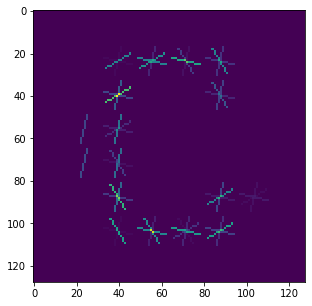

In [135]:
# Visualizando uma imagem com HOG

plt.imshow(base_hog[150])

In [0]:
# Ajustando as dimensões da base para aplicação do k-means

base_hog_ok = np.array(base_hog)
nsamples, nx, ny = base_hog_ok.shape
base_hog_final = base_hog_ok.reshape((nsamples,nx*ny))

In [0]:
# Construindo os modelos na base HOG

# K-means
final_teste['pred_y_kmeans_hog'] = kmeans_hog.predict(base_hog_final)

In [138]:
# Validação

final_teste.head()

,IMAGEM,ANOTACAO,AREA_OBJ,ALTURA,LARGURA,AREA_CONTORNO,BALAN_HOR,BALAN_VER,RAZAO,COMPACIDADE,PERIM_CONTORNO,RETANG.,EULER,AREA_FECHO,PERIM_FECHO,CONVEXIDADE,SOLIDEZ,pred_y_kmeans,pred_y_rf,pred_y_kmeans_hog
0,img013-00999,img013,262.5,68,95,6460,16.5,30.0,0.715789,792.535990,456.114785,0.040635,-1,2508.0,240.611816,0.527525,2.575758,1,B,0
1,img013-00985,img013,19.5,88,71,6248,28.5,20.0,1.239437,9626.458311,433.261973,0.003121,1,5304.0,265.673660,0.613194,1.177979,0,C,1
2,img013-00983,img013,25.5,88,71,6248,28.5,20.0,1.239437,8000.878151,451.688380,0.004081,1,5037.0,256.844223,0.568631,1.240421,0,C,1
3,img011-00856,img011,978.0,64,86,5504,21.0,32.0,0.744186,144.967169,376.534051,0.177689,0,3297.0,243.667625,0.647133,1.669396,1,A,0
4,img012-00847,img012,4432.5,89,82,7298,23.0,19.5,1.085366,21.757949,310.551297,0.607358,-1,4837.0,280.695008,0.903860,1.508786,0,B,2


In [139]:
# Validação cruzada entre o rótulo e os grupos descobertos pelo Kmeans_hog

pd.crosstab(final_teste["ANOTACAO"],final_teste["pred_y_kmeans_hog"]).apply(lambda r: r/r.sum()*100, axis=1)

pred_y_kmeans_hog,0,1,2
ANOTACAO,,,
img011,99.512195,0.487805,0.000000
img012,16.585366,2.439024,80.975610
img013,14.146341,85.365854,0.487805


In [0]:
# Predict na base HOG e já agregando a coluna ao final

final_teste['pred_y_rf_hog'] = model_rf_hog.predict(base_hog_final)

In [141]:
# Validação

final_teste.head()

,IMAGEM,ANOTACAO,AREA_OBJ,ALTURA,LARGURA,AREA_CONTORNO,BALAN_HOR,BALAN_VER,RAZAO,COMPACIDADE,PERIM_CONTORNO,RETANG.,EULER,AREA_FECHO,PERIM_FECHO,CONVEXIDADE,SOLIDEZ,pred_y_kmeans,pred_y_rf,pred_y_kmeans_hog,pred_y_rf_hog
0,img013-00999,img013,262.5,68,95,6460,16.5,30.0,0.715789,792.535990,456.114785,0.040635,-1,2508.0,240.611816,0.527525,2.575758,1,B,0,A
1,img013-00985,img013,19.5,88,71,6248,28.5,20.0,1.239437,9626.458311,433.261973,0.003121,1,5304.0,265.673660,0.613194,1.177979,0,C,1,C
2,img013-00983,img013,25.5,88,71,6248,28.5,20.0,1.239437,8000.878151,451.688380,0.004081,1,5037.0,256.844223,0.568631,1.240421,0,C,1,C
3,img011-00856,img011,978.0,64,86,5504,21.0,32.0,0.744186,144.967169,376.534051,0.177689,0,3297.0,243.667625,0.647133,1.669396,1,A,0,A
4,img012-00847,img012,4432.5,89,82,7298,23.0,19.5,1.085366,21.757949,310.551297,0.607358,-1,4837.0,280.695008,0.903860,1.508786,0,B,2,B


In [142]:
# Validação cruzada entre o rótulo e os grupos descobertos pelo RF_hog

pd.crosstab(final_teste["ANOTACAO"],final_teste["pred_y_rf_hog"]).apply(lambda r: r/r.sum()*100, axis=1)

pred_y_rf_hog,A,B,C
ANOTACAO,,,
img011,98.536585,1.463415,0.000000
img012,3.902439,95.121951,0.975610
img013,3.902439,0.000000,96.097561


In [0]:
# Exportando as bases finais

final_treino.to_csv(r'/content/base_final_treino.csv')
final_teste.to_csv(r'/content/base_final_teste.csv')

**CONCLUSÃO**

Ao final deste trabalho, podemos concluir que os modelos que utilizam HOG performaram de forma muito superior os modelos com os descritores extraídos manualmente. Isso ocorreu tanto para o modelo k-means quanto para o Random Forest.

Vale ressaltar que o modelo de árvores performou melhor quando comparado ao k-means, tanto para a versão de descritores extraídos manualmente quanto para o HOG.